# **CRPYTO PRICE PREDICTION MODEL**
## **Created by Smridh Singh**
We would be training our model. We could use SparkML or do it ourselves or both. I personally think it would be cool to do both and then compare. Doing it ourselves would entail performing stochastic gradient descent to find the optimal weights.

## **Initialization**

First we initialize Spark. This is just using code from class.

In [1]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("YourTest").master("local[2]").config("spark.driver.memory", "15g").getOrCreate()

Next, we use the Kaggle API to fetch the dataset. Steps to do this:

1. Go to your Kaggle account and download your API token. It will be a JSON file.

2. Run the code below. It will allow you to choose a file to upload - upload your API token that you just downloaded

3. All the CSV files will then be downloaded.

In [2]:
!pip install kaggle
from google.colab import files
import os

if not os.path.exists("kaggle.json"):
  files.upload()
  os.system("mkdir ~/.kaggle")
  os.system("cp kaggle.json ~/.kaggle/")
  os.system("chmod 600 ~/.kaggle/kaggle.json")
  os.system("kaggle datasets download -d leopeng2019/cryptocurrency-historical-1minprices")

!unzip 'cryptocurrency-historical-1minprices.zip'


Archive:  cryptocurrency-historical-1minprices.zip
replace ada.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Now read the CSV files into a Spark dataframe

In [3]:
from pyspark.sql.functions import lit

#get a list of all the spark dataframes
RDDByCoin = []
coins = ["ada","bch","bsv","btc","btt","doge","dot","eos","etc","eth","fil",
            "ht","link","ltc","neo","qtum","sun","sushi","trx","tt","uni","xrp","yfi"]
for coin in coins:
  newCoinRDD = spark.read.csv(coin + ".csv",header = True).withColumn("coin_name", lit(coin))
  RDDByCoin.append(newCoinRDD)

#merge into one dataframe
totalCoinFrame = RDDByCoin[0]

for i in range(1,len(RDDByCoin)):
  totalCoinFrame = totalCoinFrame.union(RDDByCoin[i])



Next, we update the datatypes of the columns and remove an annoying space from the column names

In [4]:
# Rename all column names with leading/trailing spaces
def rename_columns(df):
    old_cols = df.columns
    new_cols = list(map(lambda s: s.strip(), old_cols))
    for i in range(len(old_cols)):
      if old_cols[i] != new_cols[i]:
        df = df.withColumnRenamed(old_cols[i], new_cols[i])
    return df 


In [5]:
# Convert dtypes of columns in df according to specifications in cols
#   cols is a dictionary of {col name: dtype}
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType,FloatType,TimestampType, StringType

def convert_col_dtypes(df, cols: dict):
    for c in cols:
        df = df.withColumn(c, col(c).cast(cols[c]))
    return df

# Columns and their intended types
cols = {'time': TimestampType(),
        'id': IntegerType(),
        'amount': FloatType(),
        'open': FloatType(),
        'high': FloatType(),
        'low': FloatType(),
        'close': FloatType(),
        'count': FloatType(),
        'vol': FloatType()}


In [6]:
# Read the csvs for tokens of interest (btc,eth,doge)
bitcoin = spark.read.csv('btc.csv', header = True).withColumn("coin_name", lit('btc'))
ethereum = spark.read.csv('eth.csv', header = True).withColumn("coin_name", lit('eth'))
doge = spark.read.csv('doge.csv', header = True).withColumn("coin_name", lit('doge'))

# Strip leading and trailing spaces from column names
totalCoinFrame = rename_columns(totalCoinFrame)
bitcoin = rename_columns(bitcoin)
ethereum = rename_columns(ethereum)
doge = rename_columns(doge)
totalCoinFrame = rename_columns(totalCoinFrame)

# Convert column datatypes from strings to timestamp and floats (where applicable)
totalCoinFrame = convert_col_dtypes(totalCoinFrame, cols)
bitcoin = convert_col_dtypes(bitcoin, cols)
ethereum = convert_col_dtypes(ethereum, cols)
doge = convert_col_dtypes(doge, cols)

# Create View to be used with SQL queries
bitcoin.createOrReplaceTempView('bitcoin')
ethereum.createOrReplaceTempView('etheruem')
doge.createOrReplaceGlobalTempView('doge')
totalCoinFrame.createOrReplaceTempView('crypto')



## **Exploratory Analysis**

We'll do some exploratory analysis on individual tokens. To prevent copy and pasting code, let's make some general functions!


### Functions to partition data based on time intervals
- Get (previous/next) (minute,day,week,month,year)
- Get number of transactions between two times
- Get day of the week of a given string


In [7]:
import datetime
from dateutil.relativedelta import relativedelta

# Get the number of transactions between two timestamps
#   df_name (str): Name of a DataFrame
#   start_time (str): timstamp in the form "yyyy-MM-dd HH:mm:00"
#   end_time (str): timstamp in the form "yyyy-MM-dd HH:mm:00"
def get_total_transactions(df_name, start_time, end_time):
    res = spark.sql('select * ' +\
        f'from {df_name} ' +\
        f'where "{start_time}" <= time ' +\
        f'and time <= "{end_time}"')
    return res

# Get data of the previous "interval" relative to "time" 
# Resulting DataFrame includes "time"
#   df_name (str): Name of a DataFrame
#   time (str): timstamp in the form "yyyy-MM-dd HH:mm:00"
#   interval (str/int): One of ["minute", "hour", "day", "week", "month", "year"]
#                 or a positive integer. If it is an integer, it is interpreted in minutes
def get_past(df_name, time, interval):
    # Convert time to a datetime
    str_time = time
    try:
        time = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    except:
        print('Check time format')
        return None
    if interval == 'minute':
        past = time - datetime.timedelta(minutes = 1)
    elif interval == 'hour':
        past = time - datetime.timedelta(hours = 1)
    elif interval == 'day':
        past = time - datetime.timedelta(days = 1)
    elif interval == 'week':
        past = time - relativedelta(weeks = 1)
    elif interval == 'month':
        past = time - relativedelta(months = 1)
    elif interval == 'year':
        past = time - relativedelta(years = 1)
    elif isinstance(interval, int):
        past = time - datetime.timedelta(minutes = int) 
    else:
      print('Interval must be one of: ["minute", "hour", "day", "week", "month", "year"]')
      return None
    str_past = str(past)
    res = spark.sql('select * ' +\
                    f'from {df_name} ' +\
                    f'where "{str_past}" = time')
    return res

# Get data of the next "interval" relative to "time" 
# Resulting DataFrame includes "time"
#   df_name (str): Name of a DataFrame
#   time (str): timstamp in the form "yyyy-MM-dd HH:mm:00"
#   interval (str/int): One of ["minute", "hour", "day", "week", "month", "year"]
#                 or a positive integer. If it is an integer, it is interpreted in minutes
def get_next(df_name, time, interval):
    # Convert time to a datetime
    str_time = time
    try:
        time = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    except:
        print('Check time format')
        return None
    if interval == 'minute':
        next = time + datetime.timedelta(minutes = 1)
    elif interval == 'hour':
        next = time + datetime.timedelta(hours = 1)
    elif interval == 'day':
        next = time + datetime.timedelta(days = 1)
    elif interval == 'week':
        next = time + relativedelta(weeks = 1)
    elif interval == 'month':
        next = time + relativedelta(months = 1)
    elif interval == 'year':
        next = time + relativedelta(years = 1)
    elif isinstance(interval, int):
        past = time + datetime.timedelta(minutes = int) 
    else:
      print('Interval must be one of: ["minute", "hour", "day", "week", "month", "year"]')
      return None
    str_next = str(next)
    res = spark.sql('select * ' +\
                    f'from {df_name} ' +\
                    f'where "{str_time}" <= time and time <= "{str_next}"')
    return res

# Given a date as a string of the format "yyyy-MM-dd HH:mm:00", get the day of the week
# Monday is 0, Tuesday is 1, ...., Saturday is 5, Sunday is 6
def day_of_week(time):
    try:
        time = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    except:
        print('Check time format')
        return None
    return time.weekday()

# Given a date as a string of the format "yyyy-MM-dd HH:mm:00", get the hour
def hour(time):
    try:
        time = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    except:
        print('Check time format')
        return None
    return time.hour

# Given a date as a string of the format "yyyy-MM-dd HH:mm:00", get the month
# Jan is 1, Feb is 2,,..., Dec is 12
def month(time):
    try:
        time = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    except:
        print('Check time format')
        return None
    return time.month
  




In [8]:
get_next('bitcoin', '2021-01-01 00:00:00', 'hour').show(5)

+-------------------+----------+---------+--------+--------+--------+--------+------+---------+---------+
|               time|        id|   amount|    open|    high|     low|   close| count|      vol|coin_name|
+-------------------+----------+---------+--------+--------+--------+--------+------+---------+---------+
|2021-01-01 00:00:00|1609430400|227.52574|28779.15| 28833.0|28763.48|28822.69|2143.0|6553066.0|      btc|
|2021-01-01 00:01:00|1609430460|186.73392|28822.69| 28833.0|28719.48|28728.99|2260.0|5377881.0|      btc|
|2021-01-01 00:02:00|1609430520| 110.8757|28729.22|28746.63| 28700.0| 28700.0|1843.0|3183016.0|      btc|
|2021-01-01 00:03:00|1609430580|52.740314|28700.72|28718.89| 28700.0| 28700.0| 983.0|1513759.2|      btc|
|2021-01-01 00:04:00|1609430640| 45.09107|28700.01|28739.17|28684.27|28721.73|1268.0|1294242.2|      btc|
+-------------------+----------+---------+--------+--------+--------+--------+------+---------+---------+
only showing top 5 rows



### Functions to get stats from data
- Get max/min row of a column in a dataframe
- Get average of a column in a dataframe

In [9]:
# Get the record from the dataframe "df_name" containing the maximum value in 'col_name'
# df_name (str)
# col_name (str): 
def get_max(df_name, col_name):
    res = spark.sql('select * ' +\
                    f'from {df_name}, (' +\
                      f'select MAX({col_name}) as hi '+\
                      f'from {df_name} ' +\
                      ') as maxs ' +\
                    f'where {df_name}.{col_name} = maxs.hi')
    return res

# Get the record from the dataframe "df_name" containing the minimum value in 'col_name'
# df_name (str)
# col_name (str)
def get_min(df_name, col_name):
    res = spark.sql('select * ' +\
                    f'from {df_name}, (' +\
                      f'select MIN({col_name}) as hi '+\
                      f'from {df_name} ' +\
                      ') as maxs ' +\
                    f'where {df_name}.{col_name} = maxs.hi')
    return res

# Get the average of the column over a dataframe
# df DataFrame)
# col_name (str)
def get_avg(df, col_name):
    res = df.agg({col_name: 'avg'})
    return res.collect()[0][0]

In [10]:
get_max("bitcoin", "high").show(5)
get_min("bitcoin", "count").show(5)
print('bitcoin closing average: ', get_avg(bitcoin, 'close'))

+-------------------+----------+--------+--------+--------+--------+--------+------+---------+---------+--------+
|               time|        id|  amount|    open|    high|     low|   close| count|      vol|coin_name|      hi|
+-------------------+----------+--------+--------+--------+--------+--------+------+---------+---------+--------+
|2021-04-14 14:14:00|1618380840|72.75899|64795.71|64843.03|64670.53|64698.07|2735.0|4711909.5|      btc|64843.03|
+-------------------+----------+--------+--------+--------+--------+--------+------+---------+---------+--------+

+-------------------+----------+------+-------+-------+-------+-------+-----+---+---------+---+
|               time|        id|amount|   open|   high|    low|  close|count|vol|coin_name| hi|
+-------------------+----------+------+-------+-------+-------+-------+-----+---+---------+---+
|2020-03-05 01:31:00|1583343060|   0.0|8728.66|8728.66|8728.66|8728.66|  0.0|0.0|      btc|0.0|
|2020-03-05 01:32:00|1583343120|   0.0|8728.6

### More specific Functions
- Length of previous run (For how many minutes has the price been increasing/decreasing)
- Fluctuation of a column in the dataset (max - min)
- Slope of Secant Line (last - first)/(num_records)

In [11]:
# Length of previous run (For which minutes minutes has the price been increasing)
# earliers -> latest
# df2.open, df2.close, df1.open, df1.close
def increasing_runs(df_name):
    res = spark.sql("select df1.id, df1.time as new_time, df2.time as prev_time, df1.open as new_open, " +\
                    "df1.close new_close, df2.open as prev_open, df2.close as prev_close " +\
              f"from {df_name} as df1, {df_name} as df2 " +\
              f'where ((bigint(df1.time) - bigint(df2.time))/(60)) = 1 ' +\
                f'and df1.open >= df2.close and df1.close >= df1.open and ' +\
                'df2.close >= df2.open')
    return res

# Length of previous run (For which minutes minutes has the price been decreasing)
def decreasing_runs(df_name):
    res = spark.sql("select df1.id, df1.time as new_time, df2.time as prev_time, df1.open as new_open, " +\
                    "df1.close new_close, df2.open as prev_open, df2.close as prev_close " +\
              f"from {df_name} as df1, {df_name} as df2 " +\
              f'where ((bigint(df1.time) - bigint(df2.time))/(60)) = 1 ' +\
                f'and df1.open <= df2.close and df1.close <= df1.open and ' +\
                'df2.close <= df2.open')
    return res

# Determine the difference between the max value of a column and the min in a dataset
def fluctuation(df, col_name):
     max = df.agg({col_name: 'max'}).collect()[0][0]
     min = df.agg({col_name: 'min'}).collect()[0][0]
     return max - min

# Determine the slope of  the secant line "col_name" in the dataframe
# df (DataFrame)
# df_name (str)
# secant is calculated (earliest_record - latest_record)/(count of records)
def secant(df, df_name, col_name):
    # Get the index of the column with col_name
    cols = df.schema.fieldNames()
    try:
      i = cols.index(col_name)
    except:
      print('check col_name')
      return None
    # Get the value of 'col_name' of the earliest record
    first = get_min(df_name, 'time').collect()[0][i]
    print(first)
    # Get the value of 'col_name' of the most recent record
    last = get_max(df_name, 'time').collect()[0][i]
    print(last)
    return (last - first)/df.count()


In [12]:
# All the records where id is increasing in the past hour
prev_hour = get_past('bitcoin','2021-02-01 00:00:00', 'hour')
prev_hour.createOrReplaceTempView('prev_hour')
inc_runs = increasing_runs('prev_hour')
inc_runs.show(5) 

+---+--------+---------+--------+---------+---------+----------+
| id|new_time|prev_time|new_open|new_close|prev_open|prev_close|
+---+--------+---------+--------+---------+---------+----------+
+---+--------+---------+--------+---------+---------+----------+



## Bitcoin Only
A summary of our bitcoin data

In [13]:
bitcoin.describe().show()
print('Earliest date: ', bitcoin.agg({'time': 'min'}).collect()[0][0])
print('Latest date: ', bitcoin.agg({'time': 'max'}).collect()[0][0])

+-------+--------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+---------+
|summary|                  id|           amount|              open|              high|               low|             close|            count|              vol|coin_name|
+-------+--------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+---------+
|  count|              720600|           720600|            720600|            720600|            720600|            720600|           720600|           720600|   720600|
|   mean|        1.59942597E9|28.14799621911759|21195.810476006798|21210.585605538883|21180.805883779238|21195.861393141076|497.0052733832917|530415.2355742604|     null|
| stddev|1.2481166779592363E7|59.00357123195646|17858.272283483435|17873.054078929654|17843.404202435955|17858.292884577717|692.1520085278858|113


- 720,600 records 
- From Jan 1, 2020 to May 15, 2021 (Beijing Time)
- Average Bitcoin traded in each minute is 28.15 with a standard deviation of 59
  - The most bitcoin traded in a minute was 3315.3396 (at 2020-06-02 22:46:00)
- Average price in this time frame is approximately \$21200 USDT (with standard deviation of ~\$17800 USDT)
  - Reached a high of \$64843.03 USDT (at 2021-04-14 14:14:00)
  - Low of \$3800.00 USDT (2020-03-13 10:16:00)
- Average transactions in a minute is 497, with a standard deviation of 692.
  - Some minutes with no transactions! 
  - Most transactions in a minute was 37390



Some SQL queries used to find specfic rows in the data.

In [14]:
# The most bitcoin was traded:
print("Most # of Bitcoin traded:")
spark.sql('select * ' +\
          f'from bitcoin ' +\
          f'where amount > 3315').show()

# When was the maximum bitcoin price reached (IN USDT)
print("Peak Bitcoin Price")
spark.sql('select * ' +\
          f'from bitcoin ' +\
          f'where high > 64800').show()

# Bitcoin's lowest price in this dataset occured:
print("Lowest Bitcoin Price")
spark.sql('select * ' +\
          f'from bitcoin ' +\
          f'where low <= 3800').show()

# How often are there no transactions?
print("No Transactions")
spark.sql('select COUNT(*) ' +\
          f'from bitcoin ' +\
          f'where count = 0').show()


Most # of Bitcoin traded:
+-------------------+----------+---------+--------+-------+-------+-------+-------+-----------+---------+
|               time|        id|   amount|    open|   high|    low|  close|  count|        vol|coin_name|
+-------------------+----------+---------+--------+-------+-------+-------+-------+-----------+---------+
|2020-06-02 22:46:00|1591109160|3315.3396|10111.86|10113.0|9768.55|9774.14|13910.0|3.2884318E7|      btc|
+-------------------+----------+---------+--------+-------+-------+-------+-------+-----------+---------+

Peak Bitcoin Price
+-------------------+----------+--------+--------+--------+--------+--------+------+---------+---------+
|               time|        id|  amount|    open|    high|     low|   close| count|      vol|coin_name|
+-------------------+----------+--------+--------+--------+--------+--------+------+---------+---------+
|2021-04-14 14:14:00|1618380840|72.75899|64795.71|64843.03|64670.53|64698.07|2735.0|4711909.5|      btc|
+---

,time,total_transactions
0,2020-08-24,303444.0
1,2021-01-27,1333915.0
2,2020-01-21,153447.0
3,2020-07-24,334599.0
4,2020-08-05,369935.0


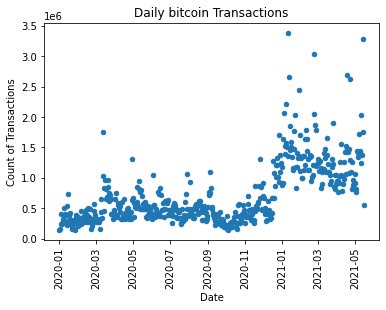

In [15]:
# Plot daily transaction from start time - end time
#   df_name (str): Name of the dataframe
#   start_time (str): timstamp in the form "yyyy-MM-dd HH:mm"
#   end_time (str): timstamp in the form "yyyy-MM-dd HH:mm"
def plot_daily_transactions(df_name, start = '2020-01-01', end = '2021-05-15'):
    data = spark.sql('select cast(time as DATE), sum(count) as total_transactions ' +\
                     f'from {df_name} ' +\
                     f'where "{start}" <= cast(time as DATE) and cast(time as DATE) <= "{end}" '
                     f'group by cast(time as DATE)')
    res = data.toPandas()
    res['time'] = pd.to_datetime(res['time'])
    res.plot(x = 'time', y= 'total_transactions', xlabel = 'Date', 
             ylabel='Count of Transactions', title= f'Daily {df_name} Transactions',
             kind = 'scatter', rot = 90)
    return res.head()
    
plot_daily_transactions('bitcoin')

In [16]:
#spark.sql('select datename(weekday, ')

In [17]:
# Ethereum Only
ethereum.describe().show()
print('Earliest date: ', ethereum.agg({'time': 'min'}).collect()[0][0])
print('Latest date: ', ethereum.agg({'time': 'max'}).collect()[0][0])

+-------+--------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+---------+
|summary|                  id|           amount|             open|             high|              low|            close|             count|               vol|coin_name|
+-------+--------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+---------+
|  count|              720600|           720600|           720600|           720600|           720600|           720600|            720600|            720600|   720600|
|   mean|1.5994259175437136E9|571.1394493828675|736.2464849492586|736.9328086850699|735.5576745359097|736.2517928575404|404.06734388009994|380534.72234344226|     null|
| stddev|1.2481254966787193E7|1101.445296020103|810.8080126089177|811.6869546090837|809.9363864708872|810.8167532408693| 608.2200230792427| 861413.49267172

### Ethereum Only
- 720,600 records 
- From Jan 1, 2020 to May 15, 2021 (Beijing Time)
- Average Ethereum traded in each minute is 571.14 with a standard deviation of 1101.44
  - The most ethereum traded in a minute was 59106.71 (WHEN)
- Average price in this time frame is approximately \$736 USDT (with standard deviation of ~\$810 USDT)
  - Reached a high of \$4371.54 USDT (WHEN)
  - Low of \$87.0 USDT (WHEN)
- Average transactions in a minute is 404, with a standard deviation of 608.
  - Some minutes with no transactions! (HOW MANY?)
  - Most transactions in a minute was 30250 (WHEN?)



## **Plotting Two Variables Against Each Other**

The assumption for this function will be that the data is organized in a dataframe where:

1. Each row represents data for one specific coin for one specific minute
2. There is a column in the dataframe which serves as some coin identifier. For example *coin_name* in myDF below.

Also note, the times plotted will be 12:00 pm and 12:00 am since reading all the data into a Pandas dataframe leads to memory overflow.


In [18]:



print(myDF.memory_usage())


NameError: ignored

In [ ]:
myDF.head(10)

In [ ]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt

myDF['y'] = (myDF['y'] - myDF['close'])/(myDF['close'])

#this is the function that will perform the plotting
def plotter(x,y, coins):
  plt.rcParams["figure.figsize"] = [8,8]
  plt.xlabel(x.title())
  plt.ylabel(y.title())
  plt.title(f"{x.title()} Vs. {y.title()}")
  plt.style.use('dark_background')
  for coin in coins:
    filteredDF = myDF[myDF.coin_name == coin]
    plt.plot(filteredDF[x],filteredDF[y],label = coin,marker = "o",linestyle = "None",markersize = 3.5)
    plt.legend()

inputs = widgets.Box(children = [
    widgets.SelectMultiple(description = "Coin(s)",options = myDF["coin_name"].unique(),value = ["btc"]),
    widgets.Select(description = "X Variable", value = "low",options = myDF.columns.values.tolist()),
    widgets.Select(description = "Y Variable", value = "high", options = myDF.columns.values.tolist())])

#add interactivity to the plot so that the user can pick what coin along with what information they want to see
widgets.interact(plotter,  x = inputs.children[1], y = inputs.children[2],coins = inputs.children[0])

## **Building the Model Manually**

First, we get all of the features into a data frame and then perform normalization of those features.

In [22]:
totalDF = spark.sql('''SELECT
                      CASE
                        WHEN coin_name == 'ada' THEN 1 ELSE 0
                      END AS ada,
                      CASE
                        WHEN coin_name == 'bch' THEN 1 ELSE 0
                      END AS bch,
                      CASE
                        WHEN coin_name == 'bsv' THEN 1 ELSE 0
                      END AS bsv,
                      CASE
                        WHEN coin_name == 'btc' THEN 1 ELSE 0
                      END AS btc,
                      CASE
                        WHEN coin_name == 'btt' THEN 1 ELSE 0
                      END AS btt,
                      CASE
                        WHEN coin_name == 'doge' THEN 1 ELSE 0
                      END AS doge,
                      CASE
                        WHEN coin_name == 'dot' THEN 1 ELSE 0
                      END AS dot,
                      CASE
                        WHEN coin_name == 'eos' THEN 1 ELSE 0
                      END AS eos,
                      CASE
                        WHEN coin_name == 'etc' THEN 1 ELSE 0
                      END AS etc,
                      CASE
                        WHEN coin_name == 'eth' THEN 1 ELSE 0
                      END AS eth,
                      CASE
                        WHEN coin_name == 'fil' THEN 1 ELSE 0
                      END AS fil,
                      CASE
                        WHEN coin_name == 'ht' THEN 1 ELSE 0
                      END AS ht,
                      CASE
                        WHEN coin_name == 'link' THEN 1 ELSE 0
                      END AS link,
                      CASE
                        WHEN coin_name == 'ltc' THEN 1 ELSE 0
                      END AS ltc,
                      CASE
                        WHEN coin_name == 'neo' THEN 1 ELSE 0
                      END AS neo,
                      CASE
                        WHEN coin_name == 'qtum' THEN 1 ELSE 0
                      END AS qtum,
                      CASE
                        WHEN coin_name == 'sun' THEN 1 ELSE 0
                      END AS sun,
                      CASE
                        WHEN coin_name == 'sushi' THEN 1 ELSE 0
                      END AS sushi,
                      CASE
                        WHEN coin_name == 'trx' THEN 1 ELSE 0
                      END AS trx,
                      CASE
                        WHEN coin_name == 'tt' THEN 1 ELSE 0
                      END AS tt,
                      CASE
                        WHEN coin_name == 'uni' THEN 1 ELSE 0
                      END AS uni,
                      CASE
                        WHEN coin_name == 'xrp' THEN 1 ELSE 0
                      END AS xrp,
                      CASE 
                        WHEN SUBSTRING(time,12,2) IN ('00','01','02','03','04','05') THEN 1 ELSE 0
                      END AS night,
                      CASE 
                        WHEN SUBSTRING(time,12,2) IN ('06','07','08','09','10','11') THEN 1 ELSE 0
                      END AS morning,
                      CASE 
                        WHEN SUBSTRING(time,12,2) IN ('12','13','14','15','16','17') THEN 1 ELSE 0
                      END AS afternoon,
                      RAND() as random_id,
                      close,
                      count,
                      vol,
                      LAG (close,20160) OVER (PARTITION BY coin_name ORDER BY time ASC) AS price_two_weeks,
                      LAG (close,43200) OVER (PARTITION BY coin_name ORDER BY time ASC) AS price_one_month,
                      ((LAG (close, 1440) OVER (PARTITION BY coin_name ORDER BY time ASC)) - close)/1440 AS roc,
                      LEAD (close,1440) OVER (PARTITION BY coin_name ORDER BY time ASC) AS y
                      FROM crypto''')

                      #time,
                      #LEFT(time,10) AS day,

In [23]:
#!pip install pyspark

#get only the desired rows
totalDF = totalDF.sort('random_id',ascending = False).filter("y IS NOT NULL AND price_two_weeks IS NOT NULL AND price_one_month IS NOT NULL").drop('random_id')

#now normalize the features by subtracting the mean and dividing by the standard deviation
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

#get the columns we want to normalize
all_cols = totalDF.columns
all_cols.remove('y') #don't scale the true value

#put all the features we want to normalize into a vector
assembler = VectorAssembler(inputCols = all_cols,outputCol = "all_features")
totalDF = assembler.transform(totalDF)

#perform the normalization
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol = 'all_features',outputCol = 'scaled',withMean= True, withStd = True)
scalerFit = scaler.fit(totalDF)

#take only the column of vectors and the label
totalDF = scalerFit.transform(totalDF).select('scaled','y')

print(totalDF.take(2))


[Row(scaled=DenseVector([-0.2309, -0.2309, -0.2309, -0.2309, -0.2309, -0.2309, -0.161, -0.2309, -0.2309, -0.2309, -0.1408, -0.2309, -0.2309, -0.2309, -0.2309, -0.2309, -0.154, -0.1575, 4.3317, -0.2309, -0.1518, -0.2309, 1.7305, -0.5775, -0.5769, -0.2444, 9.892, 2.9504, -0.2447, -0.2444, 0.018]), y=0.15500999987125397), Row(scaled=DenseVector([-0.2309, -0.2309, -0.2309, -0.2309, -0.2309, -0.2309, -0.161, -0.2309, -0.2309, -0.2309, -0.1408, -0.2309, -0.2309, -0.2309, -0.2309, -0.2309, -0.154, -0.1575, -0.2309, 4.3317, -0.1518, -0.2309, -0.5779, -0.5775, -0.5769, -0.2444, -0.327, -0.2383, -0.2447, -0.2444, 0.018]), y=0.00534699996933341)]


Next, split the data into training and test sets.

In [24]:
totalDatasetSize = totalDF.count()

def convertToTuple(x):
  theList = [1]
  theList = theList + [i for i in x[0]]
  theList.append(x[1])
  return tuple(theList)


trainSet = totalDF.limit(int(0.8*totalDatasetSize)).rdd.map(tuple).map(lambda x: convertToTuple(x)).repartition(1)
trainSet.cache()
testSet = totalDF.limit(int(0.2*totalDatasetSize)).rdd.map(tuple).map(lambda x: convertToTuple(x)).repartition(1)
print(trainSet.take(2))

[(1, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.16102767355031966, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.14083185091183825, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.15399386135059734, -0.1575406103607569, 4.331677659172788, -0.23085741918679384, -0.1518006540807176, -0.23085741918679384, 1.7304713011866513, -0.5774781126811821, -0.5769026908574187, -0.2443525122303999, 9.891982331191432, 2.950389549484, -0.2447242647386857, -0.24438825087329266, 0.017973324369056676, 0.15500999987125397), (1, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.16102767355031966, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384, -0.14083185091183825, -0.23085741918679384, -0.23085741918679384, -0.23085741918679384,

Next perform sequential stochastic gradient descent on the training set. This will give us the optimal parameters. The loss function used will just be the squared difference.

In [29]:
lr = 0.001
num_features = 32 #31 features + intercept term

def obtainYHat(point,model):
  yhat = 0
  for index in range(0,num_features):
    yhat += float(point[index])*model[index]
  return yhat

def trainer(thePartition):
  counter = 0
  model = [0 for i in range(0,num_features)] #the model we will return
  buffer = [0 for i in range(0,num_features)] #buffering the batch results: batch size of 100

  for point in thePartition:
    trueValue = float(point[len(point)-1])
    yhat = obtainYHat(point,model)
    for index in range(0,num_features):
      buffer[index] += 2*(trueValue-yhat)*(-1)*float(point[index])
    if counter % 1000 == 0: #we've come to the end of a batch so update the model parameters
      model = [model[i] - lr*(buffer[i]/500) for i in range(0,num_features)] #update the model after we've buffered 500 observations
      buffer = [0 for i in range(0,num_features)] #reset the buffer
    counter += 1

  return model

model = trainSet.mapPartitions(trainer).collect()


Now that we have the model, we perform the predictions on the test set. The *predictions* RDD below will contain 2-element tuples where the first element is the true value and the second is the predicted value

In [30]:
predictions = testSet.map(lambda x: (x[-1],obtainYHat(x,model)))
print(predictions.take(10))

[(0.15500999987125397, 67.68751043936066), (0.00534699996933341, -2.410101778054834), (210.8800048828125, 199.50595811878182), (279.6300048828125, 273.9177837185613), (0.00024808000307530165, -0.843963237734852), (10.941300392150879, 9.427062097140018), (11768.650390625, 11832.516371872), (1.2325999736785889, 0.857403377555753), (250.7100067138672, 249.89620919486165), (176.73150634765625, 181.8180435782617)]
